# DeepLab

Analyzed the performances of U-Net on the task, we decided to try some different architectures, not born to be employed in the medical domain specifically, but generally considered state of the art for segmentation problems. In particular, we focused our attention of `DeepLabV3` and `DeepLabV3+`, hoping dilated convolutions and the ASPP module could improve the actual results. 

## DeepLabV3

Since we have appreciated the benefits of using regularization in U-Net, here we directly perform the same operations both during the dataset creation and the training process.

In [1]:
img_size = 256
images_path = '../data/images'
masks_path = '../data/masks'
device='cpu'

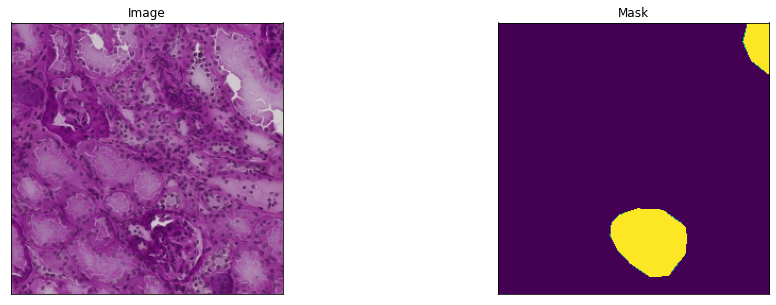

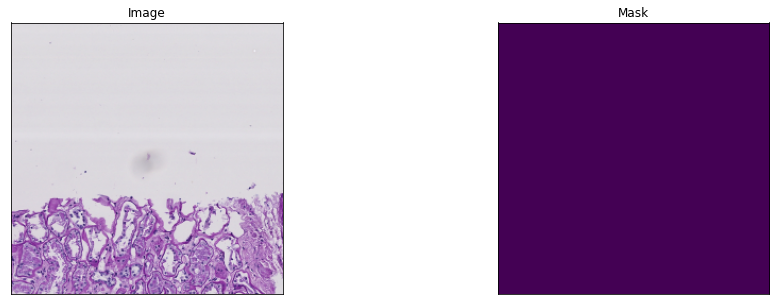

In [2]:
import itertools
from preprocess.dataset import get_training_validation_sets, denormalize_images
from visualization import visualize
from preprocess.augmentation import get_augmentations

hubmap_mean = [0.65459856, 0.48386562, 0.69428385]
hubmap_std = [0.15167958, 0.23584107, 0.13146145]

train_dataset, _, val_dataset, _ = get_training_validation_sets(
    images_path=images_path,
    masks_path=masks_path,
    validation_percentage=0.25,
    transform={'train': get_augmentations(), 'val': None},
    device=device,
    mean=hubmap_mean,
    std=hubmap_std
)

num_samples=2
for image, mask in itertools.islice(train_dataset, 0, num_samples):
    visualize(
        image=denormalize_images(image, hubmap_mean, hubmap_std), 
        mask=mask.cpu()
    )

In [3]:
from training.loss_functions import *

def get_loss_function(focal_weight: float = 0.75, dice_weight: float = 0.25):
    binary_cross_entropy = BinaryFocalLoss(gamma=0.0,
                                            alpha=0.5,
                                            device=device)
    binary_dice_loss = BinaryDiceLoss()
    return CombinationLoss([
        {'name': binary_cross_entropy, 'weight': focal_weight}, 
        {'name': binary_dice_loss, 'weight': dice_weight}
    ])

In order to make an architectural comparison, our initial idea was to fix the number of channels of the decoder (before the ASPP) from the default of 256 to 64 and set the backbone to `EfficientNet-B0` as we did for U-Net.

Unfortunately, these choices lead to poor results, therefore we decided to switch to more widely employed settings for this model, specifically `ResNet50` as the backbone and `256` as the number of channels.

In [5]:
from models import get_deeplabv3

encoder = 'resnet50'
depth = 5
channels = 256

deeplabv3, _ = get_deeplabv3(device=device,
                             encoder=encoder,
                             depth=depth,
                             decoder_channels=channels,
                             freeze_backbone=False)

In [ ]:
from training.loop import Trainer, TrainerVerbosity
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
from training.loss_functions import BinaryFocalLoss
from torch.optim.lr_scheduler import StepLR
from training.loop import EarlyStopping 

lr = 1e-3
epochs = 20
threshold = 0.5
batch_size = 32

optimizer = Adam(deeplabv3.parameters(), lr=lr, weight_decay=0)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

trainer = Trainer(threshold,
                  batch_size,
                  train_dataset,
                  val_dataset)

trainer.train(
    model=deeplabv3,
    criterion=get_loss_function(),
    optimizer=optimizer,
    epochs=epochs,
    scheduler=scheduler,
    early_stopping=EarlyStopping(num_epochs_to_stop=3),
    verbosity_level=[TrainerVerbosity.PROGRESS, TrainerVerbosity.STATISTICS],
    evaluation_verbosity_level=[TrainerVerbosity.PROGRESS, TrainerVerbosity.STATISTICS]
);

In [6]:
deeplabv3.load_state_dict(torch.load('deeplabv3.pt', map_location=torch.device(device)))

<All keys matched successfully>

You can see the charts corresponding to the training of the model we have just loaded at this [link](https://wandb.ai/mazzio97/hackingthekidney-report/runs/2jg1ok0l). Obviously, we have picked the weights from the best scoring epoch, not the last one.

As we did for U-Net, we provide some tangible proofs of the capibilities of the model showing some samples where it performs well and some others in which, on the other hand, it misses considerably the ground truth.

Some good predictions:



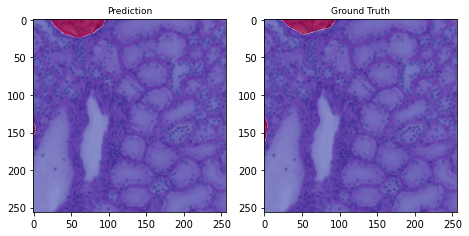

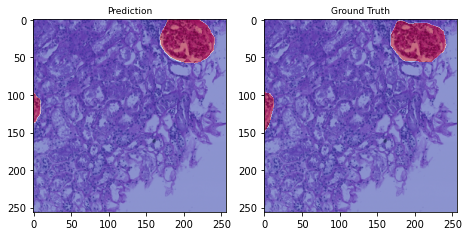

Some bad predictions:



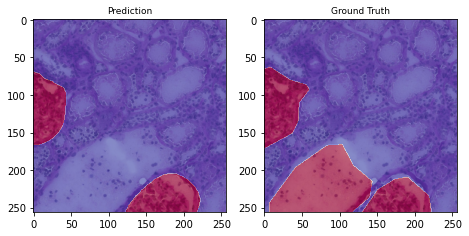

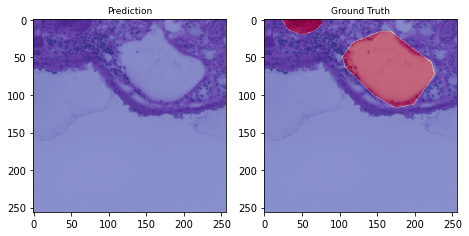

In [7]:
from evaluation.show_predictions import show_predictions

print("Some good predictions:\n")

show_predictions(
    model=deeplabv3, 
    images_path=images_path, 
    masks_path=masks_path, 
    images_to_show=2,
    mean=hubmap_mean, 
    std=hubmap_std,
    min_score_percentage=90,
    max_score_percentage=99
)

print("Some bad predictions:\n")

show_predictions(
    model=deeplabv3, 
    images_path=images_path, 
    masks_path=masks_path,
    images_to_show=2,
    mean=hubmap_mean, 
    std=hubmap_std,
    min_score_percentage=1,
    max_score_percentage=30
)

## DeepLabV3+

The results achieved by DeepLabV3 are acceptable, but conversely to our suppositions, still worse than U-Net ones.

We imputed this difference to the lack of residual connections between the encoder and the decoder, therefore we tried to use `DeepLabV3+`, which partially employs this characteristic, with the same hyperparameters configuration as the one just tested.

We are not going to analyze the results obtained by this last architecture, given its similarity in metrics with `DeepLabV3`. You can further analyze these observations at this [link](https://wandb.ai/mazzio97/hackingthekidney-report/runs/2ai7ggb6).

## Conclusions

DeepLab models, while being particularly precise on some images as we will see in the overall comparison between the selected models, generally obtain worse scores than U-Net baseline in the validation metrics. For this reason, we decided to continue our exploration on models commonly used in the medical field, like U-Net was.